# Easier Model Serving with zerocopy

*Serving deep learning models is hard, but it doesn't have to be that way.*

In a [previous post](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c), we introduced the concept of *zero-copy model loading*. Zero-copy model loading involves keeping the weights of a machine learning model in shared memory so that different processes can load the model for inference instantly without copying data.

We showed that the Plasma object store integrated into [Ray](https://www.ray.io/) makes it easy to do zero-copy model loading for [PyTorch](https://pytorch.org/) models, and that implementing this technique on Ray can accelerate model loading by several orders of magnitude. If you'd like to find out more about the details of zero-copy model loading, follow [this link](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c) to view the previous post.

In this follow-on post, we focus on how to use zero-copy model loading in deep learning model serving. We introduce `zerocopy`, a Python package that makes it extra simple to apply the technique with PyTorch and Ray. We show how to deploy models using with `zerocopy` and Ray Serve. And then we present an end-to-end model serving benchmark that shows how we can serve multiple large NLP models with a single cloud VM and achieve 7x better scalability with no tuning.

## Why is Model Serving Hard?

The architecture of model serving systems stems largely from a single design constraint: *Loading large models is expensive*. 

To run inference on a model, you need to have the model's weights loaded into a process's memory. But loading a modern deep learning model is orders of magnitude more expensive than running inference. So you need to keep the model perpetually loaded in a process's memory. Designing a deep learning model inference system reduces to answering the question, *"How do I manage models running in large, persistent processes?"* 

Different systems take different approaches to this problem. Some, like [TorchServe](https://pytorch.org/serve/) and [Ray Serve](https://docs.ray.io/en/latest/serve/index.html), run one process per model and have components for managing the resulting process pool. Others, such as [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) and [ModelMesh](https://github.com/kserve/modelmesh), maintain a small pool of large processes and have components for mapping models to processes. And other systems like [KServe](https://github.com/kserve/kserve) and [Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/overview.html#e2e-serving-with-model-servers) run each model in its container and have components for managing a container pool.

![Architecture of TorchServe, showing all the components needed to manage a pool of containers for every model.](../images/torch_serve_arch.jpg)


## A Better Way?

Regardless of the path that you take, the journey to serving deep learning models starts out at "loading models is expensive" and ends up in a place with lots of moving parts and lots of knobs to tune.

But what if we could start that journey by moving in a different direction?

That's the path we've been exploring with zero-copy model loading. Zero-copy model loading makes loading a deep learning model nearly instantaneous.  As long as the weights are in the local segment of the Ray's [Plasma object store](https://docs.ray.io/en/latest/ray-core/serialization.html#id1), your code can load a copy of the model instantly, run a single inference request, and then unload the model.  Model inference becomes a stateless process. This statelessness removes design constraints that drive complexity in model serving systems. There's no need to manage a pool of processes or containers, because inference takes place in ephemeral tasks.



In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import concurrent.futures
import requests
import starlette
import time
import os
import json
import multiprocessing

import matplotlib.pyplot as plt
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

In [2]:
# Don't include this cell in the blog post.
# Fire up Ray
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

2022-04-14 13:51:27,517	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=48955) 2022-04-14 13:51:31,909	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=48955) 2022-04-14 13:51:32,017	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:dBVTml:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-04-14 13:51:32,415	INFO api.py:521 -- Started Serve instance in namespace '79818f25-cd87-41d8-b7e4-876167a16cc3'.
(HTTPProxyActor pid=48956) INFO:     Started server process [48956]


## Introducing `zerocopy`

Our previous post included code snippets that show how to rewrite a PyTorch model to use zero-copy model loading. 
We've recently released a Python package, [`zerocopy`](https://pypi.org/project/zerocopy), that lets you apply this technique to your models without having to copy and paste Python code. 
This package is part of IBM's [Project Codeflare](https://github.com/project-codeflare), a framework to simplify the integration, scaling and acceleration of complex multi-step analytics and machine learning pipelines.

You can install this package by typing:

```
pip install zerocopy
```

Once it's installed, using the `zerocopy` package is a three-step process:
1. Import the package.
2. Move your model's weights onto the Plasma object store.
3. Run your model in an asynchronous Ray task.

Let's show these three steps in action. 

Step 1 is just a Python `import` statement:
```python 
import zerocopy
```

Then it's on to step 2: Moving your model's weights onto Plasma. You will of course need a PyTorch model to do this step. As an example, let's load up the most popular [intent detection](https://paperswithcode.com/task/intent-detection) model from the [Huggingface model marketplace](https://huggingface.co/models).

In [3]:
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            'mrm8488/t5-base-finetuned-e2m-intent')

In [4]:
# Don't include this cell in the blog.
# Load a tokenizer to go with the model and generate some preprocessed
# model inputs
tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
text = ("I came here to eat chips and beat you up, "
        "and I'm all out of chips.")
model_input = tokenizer(text, return_tensors='pt')
model_input

{'input_ids': tensor([[  27,  764,  270,   12,    3, 1544, 8852,   11, 3853,   25,   95,    6,
           11,   27,   31,   51,   66,   91,   13, 8852,    5,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

To move this model's weights onto Plasma, you first need to pass the model through `zerocopy.extract_tensors()`, which separates the weights from the model's Python objects. Then you need to copy the model and its weights to Plasma using the function `ray.put()`. You can do both of these operations with a single line of Python code. 

In [5]:
model_ref = ray.put(zerocopy.extract_tensors(model))

The return value from `ray.put()` is a Ray [object reference](https://arrow.apache.org/docs/python/plasma.html#object-ids). This object reference lets you load the model almost instantly from any location on your Ray cluster. This capability is what enables step 3: Running your model in an asynchronous Ray task.

In our previous post, we showed how you can define a stateless Ray task that loads the model, runs inference over an input, and returns the result. The `zerocopy` package includes a built-in function `call_model()` that lets you do all these steps in one line of code.

In [14]:
# Invoke the model's `generate()` method from a remote Ray task
result_ref = zerocopy.call_model.remote(model_ref, [], model_input,
                                        'generate')

As with any other Ray task, `call_model.remote()` returns a [future](https://docs.ray.io/en/latest/ray-overview/index.html#parallelizing-python-java-functions-with-ray-tasks) --- a Ray object reference to the place where the result will appear once the task has completed. You can retrieve this result with `ray.get()`.

In [15]:
ray.get(result_ref)

tensor([[   0,   12,    3, 1544, 8852,    1]])

The time to invoke the rewritten model is almost the same as running the model locally. If you run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [ ]:
print("            Time to run once locally: ", end="")
%timeit model.generate(**model_input)
print("     Time to run once with zero-copy: ", end="")
%timeit ray.get(zerocopy.call_model.remote(model_ref, [], model_input, 'generate'))

NUM_REPEATS = 100
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 [model.generate(**model_input) for _ in range(NUM_REPEATS)]
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit ray.get([zerocopy.call_model.remote(model_ref, [], model_input, 'generate') for _ in range(NUM_REPEATS)])

In [ ]:
# Don't include this cell in the blog.
# More in-depth benchmarking for internal use.
# TODO: Use output from running this cell on a large machine for the blog post
def run_local(num_repeats: int):
    for _ in range(num_repeats):
        model.generate(**model_input)


def run_zero_copy(num_repeats: int):
    futures = [
        zerocopy.call_model.remote(model_ref, [],
                                   model_input, 'generate')
        for _ in range(num_repeats)]
    ray.get(futures)


def run_zero_copy_2(num_repeats: int):
    num_cores = multiprocessing.cpu_count()
    num_not_started = num_repeats
    futures = []
    # Keep `num_cores` tasks live at a time
    while num_not_started > 0:
        addl_futures = [
            zerocopy.call_model.remote(model_ref, [],
                                       model_input, 'generate')
            for _ in range(min(num_not_started, num_cores - len(futures)))]
        num_not_started -= len(addl_futures)
        futures.extend(addl_futures)
        ready, futures = ray.wait(futures)
        ray.get(ready)
    # Fetch remaining results
    ray.get(futures)


print(f"Time to run {NUM_REPEATS} times with zero-copy 2: ", end="")
%timeit -r 3 run_zero_copy_2(NUM_REPEATS)
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
# print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
# %timeit -r 3 run_local(NUM_REPEATS)

What about memory consumption? In order for the model to load instantly, a copy of the serialized model and its weights needs to be in the local Plasma shared memory segment. The serialized data for this example model occupies a total of 990 MB in Plasma. This amount is much less than the amount of memory required by a Python process loads this model in the conventional way. We wrote a [simple test script](./space_benchmark.py) that loads the model and performs a single inference request. When we measured the script's peak memory usage, we found it to be 2350 MB, almost 2.4 times larger than the zero-copy version.

Where does this factor of 2.4 come from? There are three primary reasons. The first factor is the additional size of Python and C++ objects and bytecode, compared with the serialized Python model. The second factor is fragmentation and buffer reuse in PyTorch's memory manager. And the third factor is space that PyTorch needs for the temporary objects it creates while loading the model or running inference.

In [16]:
# Don't include this cell in the blog
# Remove the result object to clarify the output of the next cell
del(result_ref)

In [17]:
# Don't include this cell in the blog
!ray memory --units MB | grep MB

990.39025 MB         2, (990.39025 MB)  0, (0.0 MB)   0, (0.0 MB)    0, (0.0 MB)          5, (0.0 MB)  
127.0.0.1     | 48925    | Driver  |           | 990.39025 MB | LOCAL_REFERENCE | 00ffffffffffffffffffffffffffffffffffffff0100000001000000


If you load the model in multiple processes in the non-zero-copy way, each process will require that entire 2350 MB allocation. If the size of this process pool exceeds physical RAM, the virtual memory system will start to thrash, and the entire machine will become unstable.

In contrast, when Plasma runs out of space in main memory, it can spill less-frequently-used objects to a local solid state drive (SSD). The time it takes to read spilled objects back depends on the speed of the SSD. For example, the [Samsung 980 Pro](https://www.samsung.com/us/computing/memory-storage/solid-state-drives/980-pro-pcie-4-0-nvme-ssd-2tb-mz-v8p2t0b-am), a consumer-grade SSD, has a sequential read rate of 7000 MB/sec. At that rate, it would take about 140 milliseconds to read our serialized model back into main memory. Ray's scheduler can hide this loading time by overlapping it with tasks whose data is already in memory.

## Serving Models with Zero-Copy Model Loading

We've just shown how the `zerocopy` library lets you transform code that loads and runs a PyTorch model into code that copies the model to the Plasma object store and farms out inference requests to ephemeral Ray tasks.

You can use this ability to transform your model serving code into zero-copy model serving code. The pair of listings below shows how, by changing two lines of code, we can turn a [Ray Serve](https://docs.ray.io/en/latest/serve/index.html) deployment of our example intent model into a deployment that uses zero-copy model loading.

![before and after](../images/before_after.png)

Let's zoom in on the two lines that change.

The Ray Serve deployment on the left attaches the model to a Ray [actor](https://docs.ray.io/en/latest/ray-core/actors.html), a persistent Python object that resides in a dedicated process. The actor also handles incoming HTTP requests.

The constructor for the actor class contains this line of code, which loads the model from disk and stores a pointer to the resulting Python object.
```python
self._model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            'mrm8488/t5-base-finetuned-e2m-intent')
```

In the zero-copy version of the Ray Serve deployment, we replace this line of code with code that loads the model, copies the model to Plasma, and stores a Ray object reference locally.
```python
self._model_ref = zerocopy.extract_tensors(
            transformers.AutoModelForSeq2SeqLM
            .from_pretrained('mrm8488/t5-base-finetuned-e2m-intent'))
```

The second line that changes is in the actor's `__call__()` method, which handles HTTP requests. The original version of this method contains this line of code, which invokes the `generate()` method on the PyTorch model directly.
```python
raw_output = self._model.generate(**tokens)
```

We replace this line of code with a line that uses the `zerocopy.call_model()` function to run model inference in a stateless Ray background task.
```python
raw_output = await zerocopy.call_model.remote(
            self._model_ref, [], tokens, 'generate')
```

Note the use of the `await` keyword. The revised `__call__()` method uses Python's [asyncio framework](https://docs.python.org/3/library/asyncio.html) to handle multiple simultaneous requests at once. Each active request will use a separate Ray task to run model inference.

These two changes change the Ray actor from a large, heavyweight process into a much more lightweight process that only performs HTTP request handling and data proprocessing. All the work of inference occurs in stateless background tasks.

In [23]:
@serve.deployment
class MyDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        self._tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
        
        # Model loading
        self._model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
            'mrm8488/t5-base-finetuned-e2m-intent')

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "context": "<input text>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        text = json_request['context']

        # Preprocessing
        tokens = self._tokenizer(text, return_tensors='pt')

        # Model inference
        raw_output = self._model.generate(**tokens)

        # Postprocessing
        result_string = self._tokenizer.decode(raw_output[0])
        result_string = result_string.replace('<pad>', '')
        result_string = result_string[len(' '):-len('</s>')]

        return {'intent': result_string}


In [21]:
@serve.deployment
class ZeroCopyDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        self._tokenizer = transformers.AutoTokenizer.from_pretrained('t5-base')
        
        self._model_ref = zerocopy.extract_tensors(
            transformers.AutoModelForSeq2SeqLM
            .from_pretrained('mrm8488/t5-base-finetuned-e2m-intent'))

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "context": "<input text>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        text = json_request['context']

        # Preprocessing
        tokens = self._tokenizer(text, return_tensors='pt')

        raw_output = await zerocopy.call_model.remote(
            self._model_ref, [], tokens, 'generate')

        # Postprocessing
        result_string = self._tokenizer.decode(raw_output[0])
        result_string = result_string.replace('<pad>', '')
        result_string = result_string[len(' '):-len('</s>')]

        return {'intent': result_string}


In [22]:
# Don't include this cell in the blog.
# Deploy and verify correctness.
ZeroCopyDeployment.options(name='my_model', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model',
      '''
      { 
         "context": "I'm looking for some Windows drivers for a model 3X-Q." 
      }
      ''').text)

2022-04-14 15:50:56,866	INFO api.py:262 -- Updating deployment 'my_model'. component=serve deployment=my_model
(ServeController pid=48955) 2022-04-14 15:50:56,924	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model'. component=serve deployment=my_model
2022-04-14 15:51:05,880	INFO api.py:274 -- Deployment 'my_model' is ready at `http://127.0.0.1:8000/my_model`. component=serve deployment=my_model


{
  "intent": "to be able to use the latest drivers"
}


In [25]:
# Don't include this cell in the blog.
# Stop this notebook's copy of Ray so as not to interfere with the
# copy in our other notebooks.
serve.shutdown()
ray.shutdown()

## A Simple Benchmark

We created a simple benchmark to test how well a model deployed with zero-copy model loading can adjust its configuration on the fly to handle a dynamic, bursty stream of application requests. The end-to-end scenario for our benchmark involves supporting an AI chatbot for customer care. The chatbot's conversational AI uses a preprogrammed [dialog flow](https://www.ibm.com/cloud/architecture/tutorials/watson_conversation_support?task=6) to control the interaction with the customer. Some of the nodes of this flow use machine learning models to guide their decisions.

Our benchmark covers the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent detection* models that determine what is the user's goal.
* *Sentiment analysis* models that monitor the user's mood.
* *Question answering* models that provide the answers to specific factual questions.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models.

In a real application, you would want to train custom versions of each type
of model for the topics your chatbot covers.
Since we're only interested in measuring throughput and latency, we skipped that customization
step and just used the most popular pretrained model from each category from the 
[Huggingface model marketplace](https://huggingface.co/models).

Each of these models uses a [Transformer](https://arxiv.org/abs/1706.03762)-based neural network,
with a *language model* and a task specific *head*, tuned over 
a domain-specific training set.  The table below summarizes the four models that we used.


| Task                 | Model Name                                   | Language Model  | Memory Footprint<br>(zero-copy)  | Memory Footprint<br>(non-zero-copy)
| -----------          | -----------                                  | ------------    | ------------------- | ---------------------
| Intent Detection     | `mrm8488/t5-base-finetuned-e2m-intent`       | T5              | 990 MB              | 2350 MB
| Sentiment Analysis   | `cardiffnlp/twitter-roberta-base-sentiment`  | RoBERTa         | 498 MB              | 1160 MB
| Question Answering   | `deepset/roberta-base-squad2`                | RoBERTa         | 496 MB              | 1189 MB
| Text Generation      | `gpt2`                                       | GPT-2           | 665 MB              | 1391 MB

![Image of the above table, for insertion in Medium](../images/models_table.png)


Although all four models came from the same marketplace, they are quite diverse. The models use three different core language models: [Text-to-Text Transfer Transformer](https://arxiv.org/pdf/1910.10683.pdf) (T5) from Google Research, 
[RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) from Facebook AI, and [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf) from OpenAI. The models vary in size by almost a factor of 3.

<!--
The models also use two very different ways to package their preprocessing and postprocessing code. The intent and sentiment models provide small blocks of reference Python code, with the intent being that the user will adapt this reference code to the specific circumstances of the end-to-end appliction. The question answering and text generation models both use the Transformers library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines) to package their preprocessing and postprocesing code. 
-->


### Deploying the models

As a baseline for comparison, we deployed each of the four model types using Ray Serve endpoints. The intent detection model in the benchmark is the same model that we have been using in our example code so far in this article, so we used the code above to deploy that model.  We followed a similar process for the remaining three model types to deploy a total of 12 models. You can find the full code that we used to deploy all 12 models in [this notebook](./ray_baseline.ipynb).

We then modified this baseline deployment code to use zero-copy model loading. For each of our Ray Serve deployments, we changed two lines of code as we showed earlier in this post. Then we deployed three copies of each model for a total of 12 zero-copy model deployments. The code we used can be found in [this notebook](./ray_deploy.ipynb).


*Note (not to be included in the blog): earlier versions of this notebook implemented the baseline model deployment with TorchServe. That older version is preserved in [a separate notebook](./torchserve.ipynb).*

## Running the Benchmark

We wrote a simple discrete event simulation to simulate a variable number of customers interacting with the chatbot. Each simulated customer types a series of chat messages, waiting for a randomly-distributed "think time" between messages. Our simulation draws these thnk times randomly from a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with a mean value of 10 seconds. Each chat message results in a single model inference request, with the choice of models drawn randomly from another Poisson distribution.

The benchmark runs the simulation to generate a trace, then plays back the trace, sending requests to the backend under test and measuring the end-to-end latency of each request. We repeat this process of generating and playing back the trace, gradually ramping up the average request rate of the bursty traffic until requests start timing out. We used a timeout threshold of 5 seconds.

We ran this benchmark against our two model deployments, using the same trace of requests. Both runs used the same hardware, a 16-core [IBM Cloud VM](https://www.ibm.com/cloud/virtual-servers), to run the entire benchmark, including the client portion of the benchmark, the serving framework, and the processes that performed model inference.

The code that we used to implement the benchmark can be found [here](./benchmark.py).

### (not in blog) TorchServe baseline benchmark run

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [ ]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### (not in blog) Ray baseline benchmark run

In [ ]:
# Don't include this cell in the blog.
# Make sure the Ray models are up
try:
    INTENT_INPUT = {
        'context':
            ("I came here to eat chips and beat you up, "
             "and I'm all out of chips.")
    }
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

In [ ]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### (not in blog) Optimized benchmark run

In [ ]:
# Don't include this cell in the blog.
# Make sure the Ray models are up
try:
    INTENT_INPUT = {
        'context':
            ("I came here to eat chips and beat you up, "
             "and I'm all out of chips.")
    }
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

### (not in blog) Result analysis

In [26]:
# Don't include this cell in the blog

# Aggregate benchmark results.
def compute_stats(results_df: pd.DataFrame) -> pd.DataFrame:
    timeout_results = results_df[results_df['result_code'] != 200]
    success_results = results_df[results_df['result_code'] == 200]

    timeout_counts = (
        timeout_results
        .groupby('num_users')
        .aggregate({'request_id': 'count'})
        .rename(columns={'request_id': 'timeouts'}))
    stats = (
        success_results
        .groupby('num_users')
        .aggregate({'latency': ['mean', 'median', 'max'],
                    'request_id': 'count'}))

    # Column names come out from the aggregations all messed up
    stats.columns=['mean', 'median', 'max', 'successes']
    stats = stats.join(timeout_counts).fillna(0)
    stats['timeout_fraction'] = stats['timeouts'] / (stats['successes'] 
                                                     + stats['timeouts'])
    stats['timeouts'] = stats['timeouts'].astype(int)
    return stats


def maybe_generate_agg(prefix: str):
    '''
    Regenerate aggregate results for a benchmark run if a trace
    is present.

    :param prefix: Name of run, i.e. 'baseline' or 'zerocopy'
    '''
    if os.path.exists(f'outputs/{prefix}.csv'):
        results = pd.read_csv(f'outputs/{prefix}.csv')
        stats = compute_stats(results)
        stats.to_csv(f'outputs/{prefix}_agg.csv')


maybe_generate_agg('baseline')
maybe_generate_agg('zerocopy')
maybe_generate_agg('ray_baseline')

In [27]:
# Don't include this cell in the blog
# Load up the TorchServe baseline results
baseline_stats = pd.read_csv('outputs/baseline_agg.csv')
baseline_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.405181,0.442816,0.920758,57,0,0.000000
1,15,0.504624,0.478369,1.316841,88,0,0.000000
2,20,0.705766,0.499433,2.214844,114,0,0.000000
3,25,1.319962,1.112257,3.718396,141,0,0.000000
4,30,1.767164,0.797872,5.005147,95,76,0.444444
5,35,0.833144,0.108438,4.975030,74,125,0.628141


In [28]:
# Don't include this cell in the blog
# Load up the Ray baseline results
ray_baseline_stats = pd.read_csv('outputs/ray_baseline_agg.csv')
ray_baseline_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.411117,0.453302,0.967324,57,0,0.000000
1,15,0.492077,0.457293,1.228752,88,0,0.000000
2,20,0.671442,0.467893,2.034425,114,0,0.000000
3,25,1.065999,0.746736,3.407196,141,0,0.000000
4,30,2.309041,2.742401,4.967850,143,28,0.163743
5,35,2.235924,1.347797,4.998434,121,78,0.391960
6,40,1.959025,0.719997,4.994087,113,115,0.504386
7,45,1.575100,0.489439,4.992355,114,142,0.554688
8,50,1.311816,0.115630,5.000373,109,177,0.618881


In [29]:
# Don't include this cell in the blog
zerocopy_stats = pd.read_csv('outputs/zerocopy_agg.csv')
zerocopy_stats.head()

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.447012,0.418391,2.191628,57,0,0.0
1,15,0.471699,0.434592,1.899624,88,0,0.0
2,20,0.563979,0.440218,2.402398,114,0,0.0
3,25,0.615734,0.452039,2.400618,141,0,0.0
4,30,0.640276,0.456938,2.431353,171,0,0.0


The chart below shows the results of this benchmark. The X axis of the chart measures the number of simulated customers interacting with the chatbot. The Y axis measures what fraction of users' chat messages exceed the 5-second timeout limit.

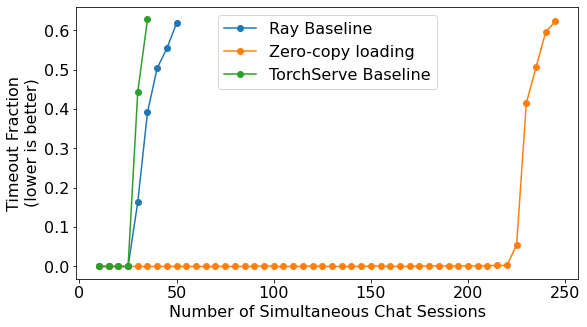

In [30]:
# Don't include this cell or its output in the blog.
# Plot the three sets of results against each other.
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9, 5))
plt.plot(ray_baseline_stats['num_users'],
         ray_baseline_stats['timeout_fraction'],
         '-o', label='Ray Baseline')
plt.plot(zerocopy_stats['num_users'],
         zerocopy_stats['timeout_fraction'],
         '-o', label="Zero-copy loading")
plt.plot(baseline_stats['num_users'],
         baseline_stats['timeout_fraction'],
         '-o', label='TorchServe Baseline')
plt.xlabel('Number of Simultaneous Chat Sessions')
plt.ylabel('Timeout Fraction\n(lower is better)')
plt.legend()
pass

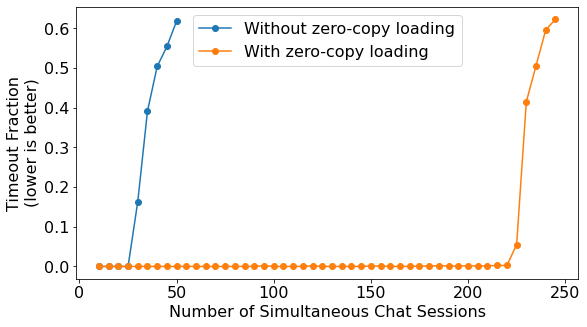

In [31]:
# Don't include this code in the blog, but do include the chart.
# Plot the two sets of results against each other.
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9, 5))
plt.plot(ray_baseline_stats['num_users'],
         ray_baseline_stats['timeout_fraction'],
         '-o', label='Without zero-copy loading')
plt.plot(zerocopy_stats['num_users'],
         zerocopy_stats['timeout_fraction'],
         '-o', label="With zero-copy loading")
plt.xlabel('Number of Simultaneous Chat Sessions')
plt.ylabel('Timeout Fraction\n(lower is better)')
plt.legend()
pass

## Benchmark Results

The chart below shows the results of the benchmark.

*Annotated copy of the above chart that doesn't change when this notebook is recomputed:*
![Performance graph](../images/zerocopy_perf.png)

The baseline deployment can handle up to 30 simultaneous chat sessions. Beyond 30 sessions, the number of timeouts increases rapidly and the system becomes unstable. The baseline deployment uses a fixed allocation of CPU and memory because it hasn't been extensively tuned. When there are more than 30 simulated customers on the line, the CPU resources that are dedicated to the model with the highest traffic can no longer keep up with the increasingly large bursts of chat messages. 

Our deployment with zero-copy model loading, on the other hand, handles up to 220 sessions without any timeouts. This performance represents a 7x improvement in scalability without any tuning. The zero-copy based deployment is able to instantly retask the underlying hardware resources to whatever models are currently experiencing high traffic.

This result shows how zero-copy model loading gives you zero-effort performance tuning.

*All the code used in this blog post is available on Project CodeFlare's Github repository [here](https://github.com/project-codeflare/zero-copy-model-loading)*.

# Extra material not included in the blog post

## Model inference pipelines


With the `zerocopy` library's `extract_tensors()` and `call_model()` functions, you can apply zero-copy model loading to a Pytorch model with three lines of Python. But what about the end-to-end program that this model came from? 

Most machine learning models require additional code to apply them in a meaningful way. NLP models in particular require *preprocessing* to convert natural language text into a format the model can understand and *postprocessing* to convert the model's answer into a format that a person can understand. 

Some models provide this preprocessing and postprocessing code as simple reference code, with the intent that someone will copy that initial version of the code and turn it into a full production-ready application.

It's also common to package the model as *pipeline* that includes preprocessing, inference, and postprocessing bundled together in a single Python object. For example, the Transformers library's BERT model that we have been using in our examples so far comes with a pipeline that performs the end-to-end task of *masked language modeling*: Identifying the most likely word to fill in a blank.

Unlike the "example reference code" approach, the Pipelines API's end-to-end inference code is intended for direct production use. It includes support for model retraining, as well as performance optimizations like batching and GPU acceleration, plus code for handling corner cases like long input strings. This prepackaged code can save a lot of time, provided that your application is structured in a way that can easily accomodate a large block of non-modifiable third-party Python code.

In [ ]:
bert_pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')
bert_pipeline('All your base are belong to [MASK].')

The `zerocopy` library includes a function `rewrite_pipeline` that transforms any models embedded into Python object into Ray tasks that use zero-copy model loading to load weights. If we apply this function to a pipeline, the resulting rewritten pipeline faithfully performs all the preprocessing and postprocessing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [ ]:
from pympler import asizeof

zero_copy_bert_pipeline = zerocopy.rewrite_pipeline(bert_pipeline)
print(f"Heap memory used before rewrite: {asizeof.asizeof(bert_pipeline)}")
print(f" Heap memory used after rewrite: {asizeof.asizeof(zero_copy_bert_pipeline)}")

print(f"Output before rewrite: {bert_pipeline('All your base are belong to [MASK].')[0]['score']}")
print(f" Output after rewrite: {zero_copy_bert_pipeline('All your base are belong to [MASK].')[0]['score']}")

In [ ]:
# Don't include this cell in the blog.
# Alternate version uses a multithreaded actor to run the pipeline via
# its __call__ method.
serve.start()

@ray.remote
class PipelineActor:
    '''
    Threaded Ray actor
    '''
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

    def run(self, input_: str):
        # Model inference calls inside this pipeline will happen in remote
        # Ray tasks.
        return self._pipeline(input_)


@serve.deployment
class MyDeployment2:
    def __init__(self):
        self._pipeline_actor = PipelineActor.options(max_concurrency=100,
                                                     num_cpus=0.1).remote()

    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()
        input_ = json_request['input']

        result = await self._pipeline_actor.run.remote(input_)
        return result

MyDeployment2.options(name='my_model2', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model2', 
      '{ "input": "All your base are belong to [MASK]." }').text)

In [ ]:
# Don't include this cell in the blog.
# Alternate version uses a thread pool and acyncio's run_in_executor()
# method run the pipeline via its __call__ method.

@serve.deployment
class MyDeployment3:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        masked_string = json_request['input']

        # The original `transformers` code is not async-aware, so we
        # call it from `run_in_executor()`.
        # Preprocessing and postprocessing code will happen inside this
        # process, but model inference will occur in a remote Ray task.
        # While that task is running, the local thread will block on
        # a call to `ray.get()`
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(masked_string))
        return result

MyDeployment3.options(name='my_model3', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model3', 
      '{ "input": "All your base are belong to [MASK]." }').text)